<a href="https://colab.research.google.com/github/rikdantas/Algoritmos-Estruturas-Dados-II/blob/main/U2T3/source/U2T3_Requisito_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U2T3
### Alunos: Ivamar Dantas Roque e Paulo Ricardo Dantas



## 1.0 Requisito 1
### Objetivo:
**Gerar uma rede (grafo) dirigida a partir dos links das páginas do Wikipédia
considerando a fusão de 4 SEEDs (páginas iniciais)**

Para isso iremos utilizar o notebook base "wikipedia", disponibilizado pelo professor

In [2]:
# Instalando biblioteca da wikipedia
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=89dbeb79db6d6591e2b213a96555a0a76b77d74511f365c4aa28a6a12274fe1c
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [3]:
# Importando bibliotecas
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt

O próximo passo é importar cada rede manualmente usando a biblioteca da wikipedia

### 1.1 Golden State Warriors

In [3]:
#https://en.wikipedia.org/wiki/Golden_State_Warriors
SEED = "Golden State Warriors".title()

In [4]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0
todo_set = set(SEED) # The SEED itself
done_set = set() # Nothing is done yet

In [5]:
gsw = nx.DiGraph()
layer, page = todo_lst[0]

In [ ]:
%%time
while layer < 2:
  # Remove the name page of the current page from the todo_lst,
  # and add it to the set of processed pages.
  # If the script encounters this page again, it will skip over it.
  del todo_lst[0]
  done_set.add(page)

  # Show progress
  print(layer, page)

  # Attempt to download the selected page.
  try:
    wiki = wikipedia.page(page)
  except:
    print("Could not load", page)
    layer, page = todo_lst[0]
    continue

  for link in wiki.links:
    link = link.title()
    if link is not link.startswith("List Of"):
      if link not in todo_set and link not in done_set:
        todo_lst.append((layer + 1, link))
        todo_set.add(link)
      gsw.add_edge(page, link)
  layer, page = todo_lst[0]

In [9]:
print("{} nodes, {} edges".format(len(gsw), nx.number_of_edges(gsw)))

98770 nodes, 378703 edges


#### 1.1.1 Pré-processamento dos dados
Nessa etapa vão ser eliminados alguns dos nós que são nós repetidos, que apontam para eles mesmos, entreo outros. Lembre que esse pré-processamento é o mesmo que o professor disponibilizou para gente.

In [7]:
# Fazendo uma cópia do grafo bruto
original = gsw.copy()

In [10]:
# remove self loops
gsw.remove_edges_from(nx.selfloop_edges(gsw))

# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s")
              for node in gsw if node + "s" in gsw
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  gsw = nx.contracted_nodes(gsw, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in
              [(node, node.replace("-", " ")) for node in gsw]
                if x != y and y in gsw]
print(duplicates)

for dup in duplicates:
  gsw = nx.contracted_nodes(gsw, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(gsw, 0,"contraction")
nx.set_edge_attributes(gsw, 0,"contraction")

[('Slam Dunk', 'Slam Dunks'), ('Altoona Mountain City', 'Altoona Mountain Citys'), ('Free Throw', 'Free Throws'), ('Nba Final', 'Nba Finals'), ('African American', 'African Americans'), ('Nba Championship', 'Nba Championships'), ('Basketball Position', 'Basketball Positions'), ('Motorsport', 'Motorsports'), ('Triple-Double', 'Triple-Doubles'), ('Regional Sports Network', 'Regional Sports Networks'), ('White American', 'White Americans'), ('Throwback Uniform', 'Throwback Uniforms'), ('Exhibition Game', 'Exhibition Games'), ('Espy Award', 'Espy Awards'), ('Triathlon', 'Triathlons'), ('Finger Roll', 'Finger Rolls'), ('Technical Foul', 'Technical Fouls'), ('Pandemic', 'Pandemics'), ('Double-Double', 'Double-Doubles'), ('Asian American', 'Asian Americans'), ('Californio', 'Californios'), ('Cambodian American', 'Cambodian Americans'), ('Chinese American', 'Chinese Americans'), ('Combined Statistical Area', 'Combined Statistical Areas'), ('Filipino American', 'Filipino Americans'), ('Francisc

In [11]:
print("{} nodes, {} edges".format(len(gsw), nx.number_of_edges(gsw)))

98474 nodes, 378578 edges


#### 1.1.2 Truncando a rede
Nessa etapa a rede vai ser truncada, aonde vão ser eliminada uma grande quantidade de nós que possuem um in degree mais baixos, pois devido o algoritmo está restringindo até a segunda camada, muitos nós tem um grau muito baixo. Com base nisso, vamos truncar a rede para diminuí-la.
Para isso primeiro vamos plotar um histograma do grau.

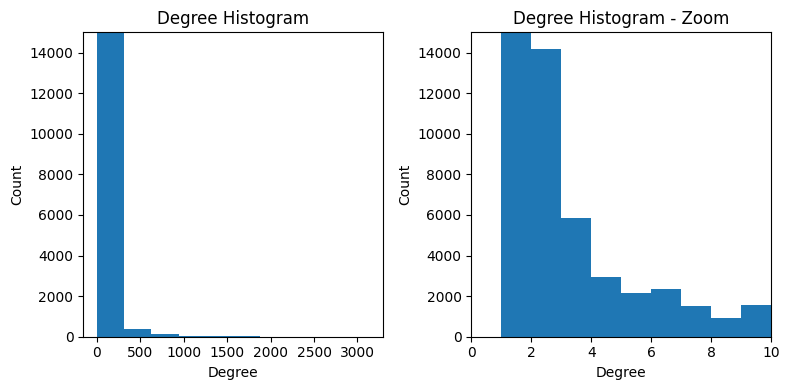

In [12]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in gsw.degree()], reverse=True)

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,15000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,15000)

plt.tight_layout()
plt.show()

Após achar um valor razoável, vamos truncar a rede, deixando apenas os nós que tiverem um grau superior ao grau estabelecido. Mesmo sabendo que isso pode interferir na análise final do trabalho, foi escolhido o grau = 50 com o intuito de enxugar a rede, pois ainda terão mais 3 que vão ser unidas com essa para gerar a rede final.


In [22]:
# filter nodes with degree greater than to 50
core = [node for node, deg in dict(gsw.degree()).items() if deg > 50]

# select a subgraph with 'core' nodes
gswsub = nx.subgraph(gsw, core)

print("{} nodes, {} edges".format(len(gswsub), nx.number_of_edges(gswsub)))

nx.write_graphml(gswsub, "gsw.graphml")

1332 nodes, 119442 edges


### 1.2 Olympic Games
Como o passo a passo vai ser o mesmo para as 4 redes, a partir desse item vão estar presentes apenas os códigos, sem texto para explicar a fim de deixar o notebook um pouco mais limpo

In [23]:
#https://en.wikipedia.org/wiki/Olympic_Games
SEED = "Olympic Games".title()

In [24]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0
todo_set = set(SEED) # The SEED itself
done_set = set() # Nothing is done yet

In [25]:
og = nx.DiGraph()
layer, page = todo_lst[0]

In [ ]:
%%time
while layer < 2:
  # Remove the name page of the current page from the todo_lst,
  # and add it to the set of processed pages.
  # If the script encounters this page again, it will skip over it.
  del todo_lst[0]
  done_set.add(page)

  # Show progress
  print(layer, page)

  # Attempt to download the selected page.
  try:
    wiki = wikipedia.page(page)
  except:
    print("Could not load", page)
    layer, page = todo_lst[0]
    continue

  for link in wiki.links:
    link = link.title()
    if link is not link.startswith("List Of"):
      if link not in todo_set and link not in done_set:
        todo_lst.append((layer + 1, link))
        todo_set.add(link)
      og.add_edge(page, link)
  layer, page = todo_lst[0]

In [29]:
print("{} nodes, {} edges".format(len(og), nx.number_of_edges(og)))

243577 nodes, 822198 edges


#### 1.2.1 Pré-processamento dos dados

In [30]:
# Fazendo uma cópia do grafo bruto
original = og.copy()

In [31]:
# remove self loops
og.remove_edges_from(nx.selfloop_edges(og))

# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s")
              for node in og if node + "s" in og
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(og, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in
              [(node, node.replace("-", " ")) for node in og]
                if x != y and y in og]
print(duplicates)

for dup in duplicates:
  og = nx.contracted_nodes(og, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(og, 0,"contraction")
nx.set_edge_attributes(og, 0,"contraction")

[('City-State', 'City-States'), ('Court Of Arbitration For Sport', 'Court Of Arbitration For Sports'), ('Demonstration Sport', 'Demonstration Sports'), ('Doping In Sport', 'Doping In Sports'), ('Gold Medal', 'Gold Medals'), ('Multi-Sport Event', 'Multi-Sport Events'), ('National Olympic Committee', 'National Olympic Committees'), ('National Anthem', 'National Anthems'), ('Olive Wreath', 'Olive Wreaths'), ('Olympiad', 'Olympiads'), ('Olympic Medal', 'Olympic Medals'), ('Silver Medal', 'Silver Medals'), ('Spartakiad', 'Spartakiads'), ('Sport', 'Sports'), ('Team Sport', 'Team Sports'), ('World War', 'World Wars'), ('Multiday Race', 'Multiday Races'), ('Relay Race', 'Relay Races'), ('World Record', 'World Records'), ('Batting Glove', 'Batting Gloves'), ('Inning', 'Innings'), ('Shin Guard', 'Shin Guards'), ('Ralph Hill', 'Ralph Hills'), ('United States Dollar', 'United States Dollars'), ('Commonwealth Games Association', 'Commonwealth Games Associations'), ('Nazi', 'Nazis'), ('Satellite Sta

In [32]:
print("{} nodes, {} edges".format(len(og), nx.number_of_edges(og)))

243388 nodes, 822086 edges


#### 1.2.2 Truncando a rede

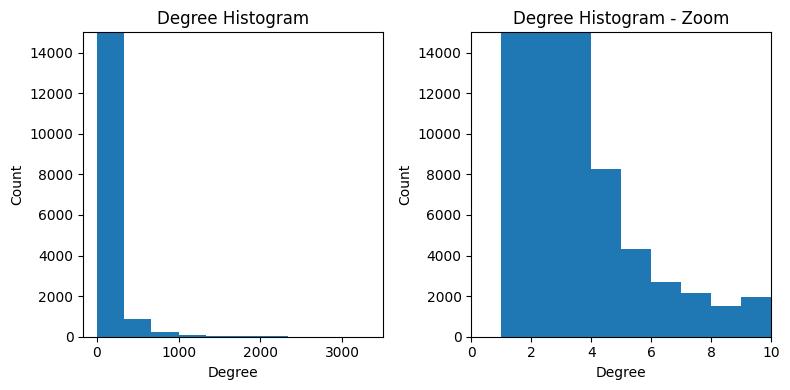

In [33]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in og.degree()], reverse=True)

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,15000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,15000)

plt.tight_layout()
plt.show()

In [41]:
# filter nodes with degree greater than to 300
core = [node for node, deg in dict(og.degree()).items() if deg > 300]

# select a subgraph with 'core' nodes
ogsub = nx.subgraph(og, core)

print("{} nodes, {} edges".format(len(ogsub), nx.number_of_edges(ogsub)))

nx.write_graphml(ogsub, "og.graphml")

1412 nodes, 214313 edges


### 1.3 Nike, Inc.

In [4]:
#https://en.wikipedia.org/wiki/Nike,_Inc.
SEED = "Nike, Inc".title()

In [5]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0
todo_set = set(SEED) # The SEED itself
done_set = set() # Nothing is done yet

In [6]:
nike = nx.DiGraph()
layer, page = todo_lst[0]

In [ ]:
%%time
while layer < 2:
  # Remove the name page of the current page from the todo_lst,
  # and add it to the set of processed pages.
  # If the script encounters this page again, it will skip over it.
  del todo_lst[0]
  done_set.add(page)

  # Show progress
  print(layer, page)

  # Attempt to download the selected page.
  try:
    wiki = wikipedia.page(page)
  except:
    print("Could not load", page)
    layer, page = todo_lst[0]
    continue

  for link in wiki.links:
    link = link.title()
    if link is not link.startswith("List Of"):
      if link not in todo_set and link not in done_set:
        todo_lst.append((layer + 1, link))
        todo_set.add(link)
      nike.add_edge(page, link)
  layer, page = todo_lst[0]

In [8]:
print("{} nodes, {} edges".format(len(nike), nx.number_of_edges(nike)))

123507 nodes, 264161 edges


#### 1.3.1 Pré-processamento dos dados

In [9]:
# Fazendo uma cópia do grafo bruto
original = nike.copy()

In [ ]:
# remove self loops
nike.remove_edges_from(nx.selfloop_edges(nike))

# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s")
              for node in nike if node + "s" in nike
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(nike, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in
              [(node, node.replace("-", " ")) for node in nike]
                if x != y and y in nike]
print(duplicates)

for dup in duplicates:
  nike = nx.contracted_nodes(nike, *dup, self_loops=False)

In [17]:
# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(nike, 0,"contraction")
nx.set_edge_attributes(nike, 0,"contraction")

In [11]:
print("{} nodes, {} edges".format(len(nike), nx.number_of_edges(nike)))

123409 nodes, 264059 edges


#### 1.3.2 Truncando a rede

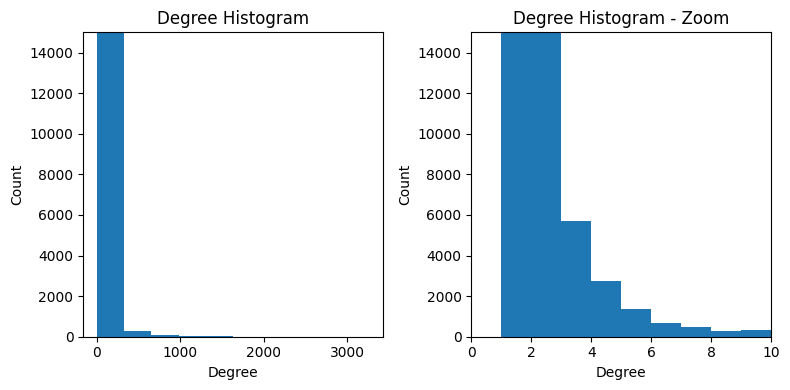

In [12]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in nike.degree()], reverse=True)

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,15000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,15000)

plt.tight_layout()
plt.show()

In [18]:
# filter nodes with degree greater than to 20
core = [node for node, deg in dict(nike.degree()).items() if deg > 20]

# select a subgraph with 'core' nodes
nikesub = nx.subgraph(nike, core)

print("{} nodes, {} edges".format(len(nikesub), nx.number_of_edges(nikesub)))

nx.write_graphml(nikesub, "nike.graphml")

971 nodes, 75637 edges


### 1.4 Tissot

In [19]:
#https://en.wikipedia.org/wiki/Tissot
SEED = "Tissot".title()

In [20]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0
todo_set = set(SEED) # The SEED itself
done_set = set() # Nothing is done yet

In [21]:
tissot = nx.DiGraph()
layer, page = todo_lst[0]

In [ ]:
%%time
while layer < 2:
  # Remove the name page of the current page from the todo_lst,
  # and add it to the set of processed pages.
  # If the script encounters this page again, it will skip over it.
  del todo_lst[0]
  done_set.add(page)

  # Show progress
  print(layer, page)

  # Attempt to download the selected page.
  try:
    wiki = wikipedia.page(page)
  except:
    print("Could not load", page)
    layer, page = todo_lst[0]
    continue

  for link in wiki.links:
    link = link.title()
    if link is not link.startswith("List Of"):
      if link not in todo_set and link not in done_set:
        todo_lst.append((layer + 1, link))
        todo_set.add(link)
      tissot.add_edge(page, link)
  layer, page = todo_lst[0]

In [23]:
print("{} nodes, {} edges".format(len(tissot), nx.number_of_edges(tissot)))

19612 nodes, 23856 edges


#### 1.4.1 Pré-processamento dos dados

In [26]:
# Fazendo uma cópia do grafo bruto
original = tissot.copy()

In [25]:
# remove self loops
tissot.remove_edges_from(nx.selfloop_edges(tissot))

# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s")
              for node in tissot if node + "s" in tissot
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(tissot, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in
              [(node, node.replace("-", " ")) for node in tissot]
                if x != y and y in tissot]
print(duplicates)

for dup in duplicates:
  tissot = nx.contracted_nodes(tissot, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(tissot, 0,"contraction")
nx.set_edge_attributes(tissot, 0,"contraction")

[('Academy Award', 'Academy Awards'), ('Golden Globe Award', 'Golden Globe Awards'), ('Rolling Stone', 'Rolling Stones'), ('Screen Actors Guild Award', 'Screen Actors Guild Awards'), ('Jiangsu Monkey King', 'Jiangsu Monkey Kings'), ('Nanjing Monkey King', 'Nanjing Monkey Kings'), ('Amphetamine', 'Amphetamines'), ('Grammy Award', 'Grammy Awards'), ('Hundred Flowers Award', 'Hundred Flowers Awards'), ('Bbc Sport', 'Bbc Sports'), ('Pocket Bike', 'Pocket Bikes'), ('Bivalve', 'Bivalves'), ('Cephalopod', 'Cephalopods'), ('Gastropod', 'Gastropods'), ('Owned-And-Operated Station', 'Owned-And-Operated Stations'), ('Primetime Emmy Award', 'Primetime Emmy Awards'), ('African American', 'African Americans'), ('Nelson Mandela Bridge', 'Nelson Mandela Bridges'), ('Merovingian', 'Merovingians'), ('Nuremberg Egg', 'Nuremberg Eggs'), ('Nandi Award', 'Nandi Awards'), ('Asset', 'Assets'), ('Velodrome', 'Velodromes')]
[('Louis-Alexandre Berthier', 'Louis Alexandre Berthier'), ('Abraham-Louis Breguet', 'Ab

In [27]:
print("{} nodes, {} edges".format(len(tissot), nx.number_of_edges(tissot)))

19608 nodes, 23849 edges


#### 1.4.2 Truncando a rede

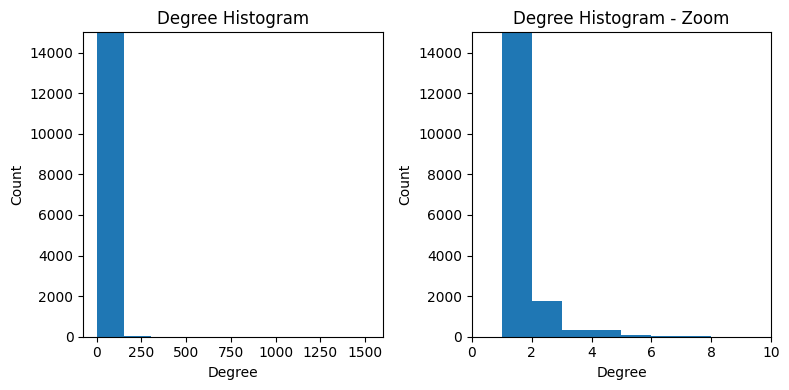

In [28]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in tissot.degree()], reverse=True)

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,15000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,15000)

plt.tight_layout()
plt.show()

In [30]:
# filter nodes with degree greater than or equal to 2
core = [node for node, deg in dict(tissot.degree()).items() if deg >= 2]

# select a subgraph with 'core' nodes
tissotsub = nx.subgraph(tissot, core)

print("{} nodes, {} edges".format(len(tissotsub), nx.number_of_edges(tissotsub)))

nx.write_graphml(tissotsub, "tissot.graphml")

2600 nodes, 6841 edges
